# Importing Libraries

In [1]:
import os
import shutil

import pandas as pd
import numpy as np

import matplotlib.pylab as plt
import seaborn as sns

import librosa
import librosa.display
from sklearn.metrics import accuracy_score,classification_report
from cough_segmentation.utils.sono_cross_val import CrossValSplit

# !sudo apt-get install p7zip-full

# Loading Dataset

In [5]:
# sample_rate, data = wavfile.read('../dataset/audio_files/0a03da19-eb19-4f51-9860-78ad95fa8cb5.wav')

# Exploring Dataset

In [6]:
# sample_rate

In [7]:
# data

In [8]:
# np.unique(data)

In [2]:
def label_cough_frames(time_frames, amp, sf):
  y = np.zeros(amp.shape[0])
  #print('len', amp.shape[0])
  for x in time_frames:
    start = int(x[0]*sf)
    end = int(x[1]*sf)
    y[start:end+1] = 1
    #print('start', f'{x[0]} sec ~ pos ', start, 'end', f'{x[1]} sec ~ pos ', end )
  return y

def get_audio_files_and_cough_timeframe_from_csv(df, audio_file_path, filename_index='uuid', start_end_time_prefix='IN_OUT_', max_start_end_count=16):
  """
  Get file names based on spreadsheet (Dataset workflow.csv) and start end time of cough

    Parameters
      df (DataFrame): Contains of filenames and start end time values of cough sounds
      filenames (list): List of filenames
      filename_index (str): Column name of the df that holds values of file names
      start_end_time_prefix (str): Optional prefix text in the column names for start and end time of cough sounds
      max_start_end_count (int): Maximum number of column names for start and end time of cough sounds
  """
  # get column names for start and end time
  col_names = [f'{start_end_time_prefix}{x}' for x in range(1,17)]

  extract_uuid = lambda file_path: os.path.splitext(os.path.basename(file_path))[0]

  amplitude_and_sampling_freq = lambda file_path: librosa.load(file_path)
  #amplitude_and_sampling_freq = lambda file_path: (np.zeros(1),0)

  dic = {"amp":[], "amp_original":[], "sf":[], "sf_original":[], "shape":[], "shape_original":[], "cough_start_end":[], "label":[]}
  files = []
  for file_name in os.listdir(audio_file_path):
    file_path = os.path.join(audio_file_path,file_name)
    uuid = extract_uuid(file_path)

    times = df[ df[filename_index] == uuid ][col_names].dropna(axis=1).values
    frame = []
    if len(times) > 0:
      frame.extend([list(map(float, x.strip().split(','))) for x in times[0] if len(x.strip().split(',')) == 2])


    files.append(uuid)
    amp, sf = amplitude_and_sampling_freq(file_path)

    #resample audio file to 16Khz based on Supervisor Request
    sf_resampled = 16000
    amp_resampled = librosa.resample(amp, orig_sr=sf, target_sr=sf_resampled)

    dic["amp"].append(amp_resampled)
    dic["amp_original"].append(amp)
    dic["sf"].append(sf_resampled)
    dic["sf_original"].append(sf)
    dic["shape"].append(amp_resampled.shape)
    dic["shape_original"].append(amp.shape)

    if len(frame) > 0:
      #print(uuid, times)
      dic["cough_start_end"].append(frame)
      dic["label"].append(label_cough_frames(frame, amp_resampled, sf_resampled))
    else:
      dic["cough_start_end"].append(np.nan)
      #30-May-24
      dic["label"].append(label_cough_frames(frame, amp_resampled, sf_resampled))


  return pd.DataFrame(dic, index=files)

def plot_amp_vs_label(title, visual_set, audio_df2, percent=0):
  for i, v in visual_set.items():
    if percent > 0:
      argmax = np.argmax(audio_df2.loc[v]["amp"])
      three_percent = len(audio_df2.loc[v]["amp"])*percent
      start_zoom = int(argmax - three_percent)
      end_zoom = int(argmax + three_percent)
      print(f'Max value {np.max(audio_df2.loc[v]["amp"])} pos {argmax} {start_zoom},{end_zoom}')
      pd.Series( audio_df2.loc[v]["amp"][start_zoom:end_zoom]).plot(figsize=(16, 4),lw=1, title=f'{i} {title} {v}')
      pd.Series( audio_df2.loc[v]["label"][start_zoom:end_zoom]).plot(figsize=(16, 4),lw=2)
    else:
      pd.Series( audio_df2.loc[v]["amp"]).plot(figsize=(16, 4),lw=1, title=f'{i} {title} {v}')
      pd.Series( audio_df2.loc[v]["label"]).plot(figsize=(16, 4),lw=2)

    plt.show()

In [3]:

df = pd.read_csv("../dataset/Dataset workflow.csv")
files = df["uuid"][df["Training"] == 1].values
audio_file_path = "../dataset/audio_files/AWS Audio Files"
audio_df = get_audio_files_and_cough_timeframe_from_csv(df, audio_file_path ,filename_index='uuid', start_end_time_prefix='IN_OUT_', max_start_end_count=16)
audio_df = audio_df.loc[files]
audio_df

,amp,amp_original,sf,sf_original,shape,shape_original,cough_start_end,label
0f8d80f9-700e-4069-924d-e15f29d7c19a,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16000,22050,"(63360,)","(87318,)","[[0.676663, 1.172248], [1.964468, 2.321861], [...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3278e364-afdd-4c39-9126-b8b4a4caf1c5,"[1.0490051e-18, 2.7095826e-19, -7.016333e-19, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16000,22050,"(156480,)","(215649,)","[[4.05953, 4.841149], [4.935187, 5.410265], [5...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6462d540-48bc-410b-b08e-cdf0b45ee118,"[2.0940916e-11, -2.2022635e-12, 1.4001382e-10,...","[-4.4392138e-12, -4.821251e-11, 2.6800558e-11,...",16000,22050,"(156480,)","(215649,)","[[0.776306, 1.76543], [2.094332, 2.619125]]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7876c549-066a-4ea1-a82e-45772114f964,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16000,22050,"(92160,)","(127008,)","[[1.014883, 1.671931], [1.671931, 2.227612]]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
ccdb32af-58f4-4718-9f6e-eec7e0020382,"[1.4889504e-13, -3.1595468e-12, 8.560125e-12, ...","[-2.8291443e-14, -1.2351532e-11, 3.1303011e-12...",16000,22050,"(156480,)","(215649,)","[[1.931091, 2.374866], [2.374866, 2.817433]]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...
c98b76a0-089e-4552-8649-2804e2d95403,"[-1.583348e-11, 1.2545295e-11, 1.750478e-11, -...","[-5.5933556e-12, 7.474474e-12, -1.630101e-11, ...",16000,22050,"(157440,)","(216972,)",NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
ce5ae235-fa9f-4ded-ba7b-623b78cf76a3,"[2.8344516e-10, 6.834763e-10, 3.7078565e-10, 3...","[1.1145103e-10, 1.7554866e-10, 5.9984917e-10, ...",16000,22050,"(21120,)","(29106,)",NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
d43e0849-42db-4442-94bf-ace2056fcffc,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",16000,22050,"(157440,)","(216972,)",NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
01424527-9c3b-4b6e-96f1-9eea3150819b,"[-2.4598084e-12, 3.4625614e-12, -2.1481796e-12...","[8.637051e-13, -2.1826378e-12, 1.930946e-12, -...",16000,22050,"(157440,)","(216972,)",NaN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [4]:
audio_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 300 entries, 0f8d80f9-700e-4069-924d-e15f29d7c19a to 0e989f65-989f-4b9a-beb7-f56e2e8ac468
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   amp              300 non-null    object
 1   amp_original     300 non-null    object
 2   sf               300 non-null    int64 
 3   sf_original      300 non-null    int64 
 4   shape            300 non-null    object
 5   shape_original   300 non-null    object
 6   cough_start_end  150 non-null    object
 7   label            300 non-null    object
dtypes: int64(2), object(6)
memory usage: 21.1+ KB


In [5]:
# audio_df2 = audio_df.dropna()
# audio_df2.info()

In [6]:
def apply_framing(audio_df):
  def create_overlapping_frames(key, amp, label, sf, frame_size, hop_length):
    # Calculate the total number of frames
    if len(amp) == len(label):
      total_frames = 1 + int((len(amp) - frame_size) / hop_length)
      dic = {"key":[], "sf":[], "start":[], "end":[], "max_amp":[], "frame_index":[], "amp":[], "label":[]}

      # Create overlapping frames
      for i in range(total_frames):
        dic["key"].append(key)
        dic["sf"].append(sf)
        dic["start"].append(i * hop_length)
        dic["end"].append(i * hop_length + frame_size)
        dic["max_amp"].append(np.max(amp[i * hop_length: i * hop_length + frame_size]))
        dic["frame_index"].append(i)
        dic["amp"].append(amp[i * hop_length: i * hop_length + frame_size])
        frames_label_raw = label[i * hop_length: i * hop_length + frame_size]

        f_label = 0
        if np.sum(frames_label_raw==1) > (len(frames_label_raw) / 2):
          f_label = 1
        dic["label"].append(f_label)

      return dic
    else:
      print('Error: non matching amp and labels', key, len(amp), len(label))

  def create_and_label_frames(audio_df):
    return create_overlapping_frames(audio_df.name, audio_df["amp"], audio_df["label"],audio_df["sf"],frame_size, hop_length)

  all_frames = {}
  for frame_size in [256, 512, 1024]:
    hop_length = frame_size // 2

    frame_df = pd.DataFrame()
    #xx = audio_df.head(1).apply(create_and_label_frames, axis=1)
    xx = audio_df.apply(create_and_label_frames, axis=1)
    for x in xx:
      if len(frame_df) > 0:
        frame_df = pd.concat([frame_df, pd.DataFrame(x)], ignore_index=True)
      else:
        frame_df = pd.DataFrame(x)

    all_frames[frame_size] = frame_df
    print(f'Frame size {frame_size}, hop_length {hop_length}, count {len(frame_df)}')
  return all_frames


all_frames = apply_framing(audio_df=audio_df)
framed_df = all_frames[1024]
framed_df

Frame size 256, hop_length 128, count 333215
Frame size 512, hop_length 256, count 166399
Frame size 1024, hop_length 512, count 82957


,key,sf,start,end,max_amp,frame_index,amp,label
0,0f8d80f9-700e-4069-924d-e15f29d7c19a,16000,0,1024,0.000000e+00,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
1,0f8d80f9-700e-4069-924d-e15f29d7c19a,16000,512,1536,0.000000e+00,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
2,0f8d80f9-700e-4069-924d-e15f29d7c19a,16000,1024,2048,0.000000e+00,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
3,0f8d80f9-700e-4069-924d-e15f29d7c19a,16000,1536,2560,1.606821e-18,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
4,0f8d80f9-700e-4069-924d-e15f29d7c19a,16000,2048,3072,1.252836e-05,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
...,...,...,...,...,...,...,...,...
82952,0e989f65-989f-4b9a-beb7-f56e2e8ac468,16000,154112,155136,1.326591e-04,301,"[-2.9675384e-06, -4.063487e-05, -3.302071e-05,...",0
82953,0e989f65-989f-4b9a-beb7-f56e2e8ac468,16000,154624,155648,9.876763e-05,302,"[-3.2297816e-05, 2.7146225e-06, -2.2797496e-05...",0
82954,0e989f65-989f-4b9a-beb7-f56e2e8ac468,16000,155136,156160,1.095975e-04,303,"[-2.1411723e-05, -3.5203106e-05, 4.4704484e-07...",0
82955,0e989f65-989f-4b9a-beb7-f56e2e8ac468,16000,155648,156672,1.095975e-04,304,"[-2.8520342e-05, -1.2514673e-05, 7.0754875e-05...",0


In [7]:

def compute_mfcc(pd_df_audio_data):
    # Extract audio data and sample rates
    audio_frames = pd_df_audio_data["amp"].apply(lambda x: np.array(x) if not isinstance(x, np.ndarray) else x)
    sample_rates = pd_df_audio_data["sf"].values

    mfccs = []
    mfccs_shapes = []
    for audio_frame, sr in zip(audio_frames, sample_rates):

        data_mfcc = librosa.feature.mfcc(y=audio_frame, sr=sr, n_fft=1024, win_length=1024, hop_length=68, n_mfcc=64)
        mfccs.append(data_mfcc)
        mfccs_shapes.append(data_mfcc.shape)

    mfccs_df = pd.DataFrame({
        "mfcc": mfccs,
        "mfcc_shape": mfccs_shapes
    }, index=pd_df_audio_data.index)

    # Concatenate additional columns from audio files dataframe
    columns_to_add = ["key", "sf", "start", "end", "max_amp", "frame_index", "amp", "label"]
    mfccs_df = pd.concat([mfccs_df, pd_df_audio_data[columns_to_add]], axis=1)

    return mfccs_df

audio_df_with_mfccs = compute_mfcc(framed_df)
audio_df_with_mfccs

,mfcc,mfcc_shape,key,sf,start,end,max_amp,frame_index,amp,label
0,"[[-1131.3708, -1131.3708, -1131.3708, -1131.37...","(64, 16)",0f8d80f9-700e-4069-924d-e15f29d7c19a,16000,0,1024,0.000000e+00,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
1,"[[-1131.3708, -1131.3708, -1131.3708, -1131.37...","(64, 16)",0f8d80f9-700e-4069-924d-e15f29d7c19a,16000,512,1536,0.000000e+00,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
2,"[[-1131.3708, -1131.3708, -1131.3708, -1131.37...","(64, 16)",0f8d80f9-700e-4069-924d-e15f29d7c19a,16000,1024,2048,0.000000e+00,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
3,"[[-1131.3708, -1131.3708, -1131.3708, -1131.37...","(64, 16)",0f8d80f9-700e-4069-924d-e15f29d7c19a,16000,1536,2560,1.606821e-18,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
4,"[[-1131.3708, -1131.3708, -1131.3708, -1131.37...","(64, 16)",0f8d80f9-700e-4069-924d-e15f29d7c19a,16000,2048,3072,1.252836e-05,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
...,...,...,...,...,...,...,...,...,...,...
82952,"[[-853.1956, -836.8685, -826.01086, -819.73444...","(64, 16)",0e989f65-989f-4b9a-beb7-f56e2e8ac468,16000,154112,155136,1.326591e-04,301,"[-2.9675384e-06, -4.063487e-05, -3.302071e-05,...",0
82953,"[[-853.5937, -836.3044, -824.3947, -816.85254,...","(64, 16)",0e989f65-989f-4b9a-beb7-f56e2e8ac468,16000,154624,155648,9.876763e-05,302,"[-3.2297816e-05, 2.7146225e-06, -2.2797496e-05...",0
82954,"[[-851.40625, -835.4931, -825.09375, -819.2154...","(64, 16)",0e989f65-989f-4b9a-beb7-f56e2e8ac468,16000,155136,156160,1.095975e-04,303,"[-2.1411723e-05, -3.5203106e-05, 4.4704484e-07...",0
82955,"[[-845.3573, -831.26227, -822.6367, -818.4535,...","(64, 16)",0e989f65-989f-4b9a-beb7-f56e2e8ac468,16000,155648,156672,1.095975e-04,304,"[-2.8520342e-05, -1.2514673e-05, 7.0754875e-05...",0


In [92]:
one_data = audio_df_with_mfccs["mfcc"][10]
one_data.shape

(64, 16)

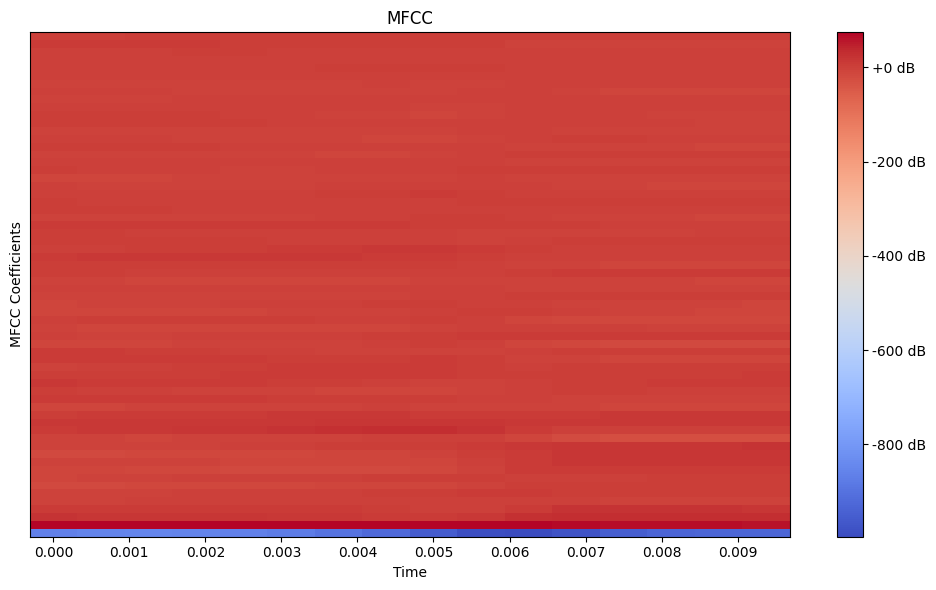

In [95]:
def plot_mfcc_spectrogram(mfcc_data, sr, title="MFCC"):
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(mfcc_data, sr=sr, x_axis='time', hop_length=10)
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("MFCC Coefficients")
    plt.tight_layout()
    plt.show()
plot_mfcc_spectrogram(one_data, sr=16000, title="MFCC")

In [9]:

mfccs_second_derivative = librosa.feature.delta(one_data, order=3, mode="nearest",width=9)
mfccs_second_derivative.shape

(64, 16)

In [79]:
def compute_mfcc_and_deltas(mfcc,order):
    final_mfcc = []
    for i in range(1,order+1):
        mfcc_delta = librosa.feature.delta(mfcc,order=order)

        if i == 1:
            mfcc_derivative = mfcc_delta
        else:
            mfcc_derivative = np.dstack((mfcc_derivative,mfcc_delta))

    final_mfcc.append(mfcc_derivative)

    final_mfcc = np.array(final_mfcc)
    return mfcc_derivative


final_mfcc_data = []
for i in audio_df_with_mfccs["mfcc"].values:
    mfcc_derivative = compute_mfcc_and_deltas(i,order=3)
    final_mfcc_data.append(mfcc_derivative)

final_mfcc_data = np.array(final_mfcc_data)
final_mfcc_data.shape

(82957, 64, 16, 3)

In [62]:
framed_df["mfccs"][0].shape

(128, 3)

In [15]:
framed_df["mfccs"][0].reshape(-1).shape

(192,)

In [16]:
# # preparing data for ml
# data = []
# for i in range(len(framed_df)):
#     data.append(framed_df["mfccs"][i].reshape(-1))
# X = np.array(data)

In [17]:
X[0].shape

(192,)

In [18]:
X.shape

(56337, 192)

# Model Building

In [19]:
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

In [88]:
# X = df_frame_from_save["mfccs"]
y = framed_df["label"]

In [89]:
y

0        0
1        0
2        0
3        0
4        0
        ..
82952    0
82953    0
82954    0
82955    0
82956    0
Name: label, Length: 82957, dtype: int64

In [22]:
y.value_counts()

label
0    44249
1    12088
Name: count, dtype: int64

In [23]:
y.value_counts()/y.shape

label
0    0.785434
1    0.214566
Name: count, dtype: float64

In [24]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [25]:
X_train[0].shape

(192,)

# Logistic Regression

In [26]:
lr = LogisticRegression(penalty="elasticnet",verbose=1,l1_ratio=0.4,solver="saga")

In [27]:
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)


max_iter reached after 19 seconds


f:\Data Science and ML\End To End ML\CE 903 - Group Project\23-24_CE903-SU_team06\venv-team06\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [28]:
accuracy_score(y_test,y_pred)

0.8774405395811147

In [29]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      8803
           1       0.76      0.64      0.69      2465

    accuracy                           0.88     11268
   macro avg       0.83      0.79      0.81     11268
weighted avg       0.87      0.88      0.87     11268



# XGBoost

In [32]:
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)


In [33]:
accuracy_score(y_test,y_pred)

0.8775292864749734

In [34]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.91      0.94      0.92      8803
           1       0.75      0.66      0.70      2465

    accuracy                           0.88     11268
   macro avg       0.83      0.80      0.81     11268
weighted avg       0.87      0.88      0.87     11268



# Preparing Data for CNN

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import metrics

In [76]:
def create_cnn_model(input_shape):
    model = Sequential([
        Conv2D(64, kernel_size=(2, 2), activation='relu', input_shape=input_shape,padding="same"),
        MaxPooling2D(pool_size=(2,2)),
        Dropout(0.2),
        Conv2D(128, kernel_size=(2, 2), activation='relu', input_shape=input_shape,padding="same"),
        MaxPooling2D(pool_size=(2,2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(8, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss="binary_crossentropy", optimizer="adam",
    metrics=[
            "accuracy",
            metrics.Precision(name='precision'),
            metrics.Recall(name='recall'),
            metrics.AUC(name='auc_roc', curve='ROC'),
            metrics.AUC(name='auc_pr', curve='PR'),
            metrics.TruePositives(name='true_positives'),
            metrics.FalsePositives(name='false_positives'),
            metrics.TrueNegatives(name='true_negatives'),
            metrics.FalseNegatives(name='false_negatives'),
])
    return model

model = create_cnn_model(input_shape=(64,14,1))
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 64, 14, 64)        320       
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 32, 7, 64)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 32, 7, 64)         0         
                                                                 
 conv2d_27 (Conv2D)          (None, 32, 7, 128)        32896     
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 16, 3, 128)       0         
 g2D)                                                            
                                                                 
 flatten_13 (Flatten)        (None, 6144)            

In [25]:
audio_mfcc = []
for i in audio_df_with_mfccs["mfcc"].values:
    audio_mfcc.append(i)
audio_mfcc = np.array(audio_mfcc).reshape(-1,64,16,1)

audio_mfcc.shape


(82957, 64, 16, 1)

Sono Cross Val Split
 StratifiedKFold(n_splits=5, random_state=6, shuffle=True) 	Total Audio Files: 300


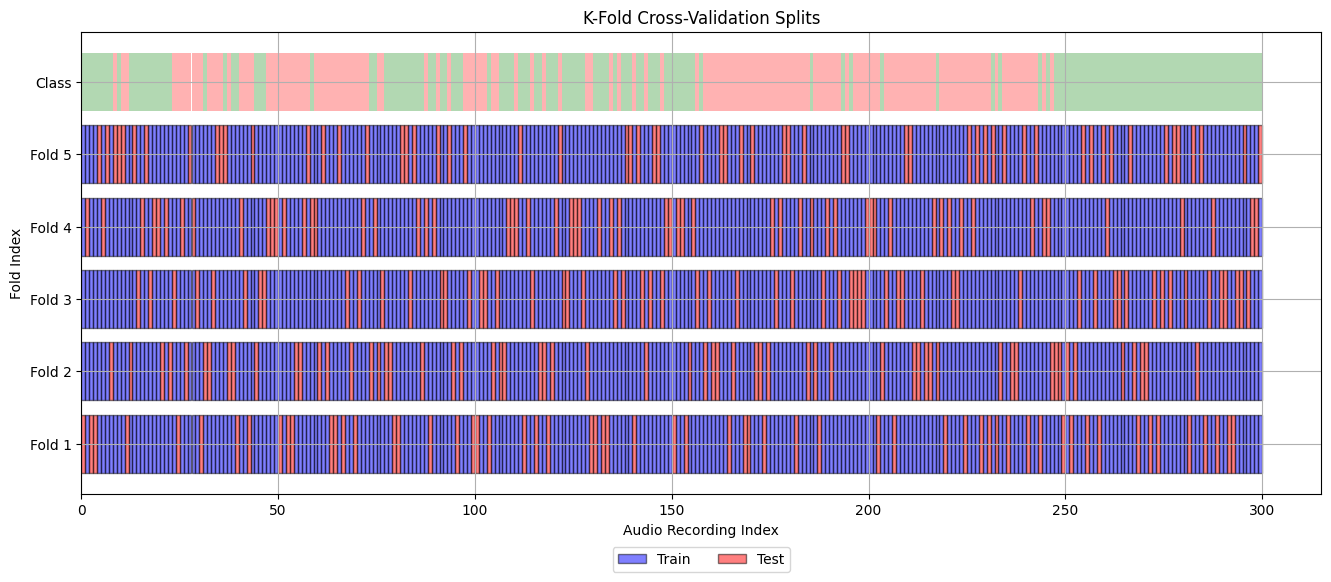

1 fold started
Epoch 1/6
1979/1979 [==============================] - 122s 61ms/step - loss: 0.1743 - accuracy: 0.9362 - precision: 0.7661 - recall: 0.5883 - auc_roc: 0.9466 - auc_pr: 0.6888 - true_positives: 4019.0000 - false_positives: 1227.0000 - true_negatives: 55256.0000 - false_negatives: 2813.0000 - val_loss: 0.1569 - val_accuracy: 0.9388 - val_precision: 0.7510 - val_recall: 0.5786 - val_auc_roc: 0.9460 - val_auc_pr: 0.7187 - val_true_positives: 1134.0000 - val_false_positives: 376.0000 - val_true_negatives: 17306.0000 - val_false_negatives: 826.0000
Epoch 2/6
1979/1979 [==============================] - 132s 67ms/step - loss: 0.1344 - accuracy: 0.9477 - precision: 0.7967 - recall: 0.6922 - auc_roc: 0.9645 - auc_pr: 0.8147 - true_positives: 4729.0000 - false_positives: 1207.0000 - true_negatives: 55276.0000 - false_negatives: 2103.0000 - val_loss: 0.1527 - val_accuracy: 0.9421 - val_precision: 0.8032 - val_recall: 0.5561 - val_auc_roc: 0.9489 - val_auc_pr: 0.7591 - val_true_pos

In [28]:
def train_with_cross_val_data():
    cv_strat = CrossValSplit(df_single_frame=audio_df_with_mfccs, non_cough_keys=audio_df[audio_df['cough_start_end'].isna()].index)
    cv_strat_data = cv_strat.cross_val(stratified=True, shuffle=True, plot=True, show_fold_info=False)

    all_histories = []
    count = 1

    for fold in cv_strat_data:
        print(f"{count} fold started")
        model = create_cnn_model(input_shape=(64,16,1))

        X_train = audio_mfcc[fold[0]]
        y_train = audio_df_with_mfccs.loc[fold[0]]["label"].values
        
        X_val = audio_mfcc[fold[1]]
        y_val = audio_df_with_mfccs.loc[fold[1]]["label"].values
        history = model.fit(X_train, y_train, epochs=6, batch_size=32, validation_data=(X_val,y_val))
        all_histories.append(history)
        count += 1
    return all_histories

all_histories = train_with_cross_val_data()

In [71]:
all_histories_new = all_histories
all_histories_new

In [35]:
all_histories[0].history

{'loss': [0.1743447631597519,
  0.13441553711891174,
  0.12499874085187912,
  0.11408466100692749,
  0.10442425310611725,
  0.09452555328607559],
 'accuracy': [0.9361920356750488,
  0.9477217197418213,
  0.9518755674362183,
  0.9553186297416687,
  0.9598199725151062,
  0.9640053510665894],
 'precision': [0.7661074995994568,
  0.7966644167900085,
  0.812758207321167,
  0.821010410785675,
  0.8382770419120789,
  0.8515830039978027],
 'recall': [0.5882611274719238,
  0.6921838521957397,
  0.7198477983474731,
  0.7492681741714478,
  0.7776639461517334,
  0.807084321975708],
 'auc_roc': [0.9465693235397339,
  0.964483916759491,
  0.9695219993591309,
  0.9742701649665833,
  0.9778785109519958,
  0.9814093112945557],
 'auc_pr': [0.6888279914855957,
  0.8147232532501221,
  0.8394414186477661,
  0.8680587410926819,
  0.8886857032775879,
  0.9075177907943726],
 'true_positives': [4019.0, 4729.0, 4918.0, 5119.0, 5313.0, 5514.0],
 'false_positives': [1227.0, 1207.0, 1133.0, 1116.0, 1025.0, 961.0],

In [45]:
all_fold_history = {
    "loss" :[],
    "accuracy":[],
    "precision":[],
    "recall":[],
    "auc_roc":[],
    "val_loss":[],
    "val_accuracy":[],
    "val_precision":[],
    "val_recall":[],
    "val_auc_roc":[],
    "true_positives":[],
    "false_positives":[],
    "true_negatives":[],
    "false_negatives":[],
    "val_true_positives":[],
    "val_false_positives":[],
    "val_true_negatives":[],
    "val_false_negatives":[],
}
# history_one = all_histories[0].history["recall"][-1]


In [46]:
for i in range(5):
    for key,val in all_fold_history.items():
        all_fold_history[key].append(all_histories[0].history[key][-1])

In [47]:
all_fold_history

{'loss': [0.09452555328607559,
  0.09452555328607559,
  0.09452555328607559,
  0.09452555328607559,
  0.09452555328607559],
 'accuracy': [0.9640053510665894,
  0.9640053510665894,
  0.9640053510665894,
  0.9640053510665894,
  0.9640053510665894],
 'precision': [0.8515830039978027,
  0.8515830039978027,
  0.8515830039978027,
  0.8515830039978027,
  0.8515830039978027],
 'recall': [0.807084321975708,
  0.807084321975708,
  0.807084321975708,
  0.807084321975708,
  0.807084321975708],
 'auc_roc': [0.9814093112945557,
  0.9814093112945557,
  0.9814093112945557,
  0.9814093112945557,
  0.9814093112945557],
 'val_loss': [0.18631598353385925,
  0.18631598353385925,
  0.18631598353385925,
  0.18631598353385925,
  0.18631598353385925],
 'val_accuracy': [0.9311169981956482,
  0.9311169981956482,
  0.9311169981956482,
  0.9311169981956482,
  0.9311169981956482],
 'val_precision': [0.6639654040336609,
  0.6639654040336609,
  0.6639654040336609,
  0.6639654040336609,
  0.6639654040336609],
 'val_re

In [48]:
# Calculate mean for each key
mean_history = {key: np.mean(value)*100 for key, value in all_fold_history.items()}

print(mean_history)

{'loss': 9.45255532860756, 'accuracy': 96.40053510665894, 'precision': 85.15830039978027, 'recall': 80.7084321975708, 'auc_roc': 98.14093112945557, 'val_loss': 18.631598353385925, 'val_accuracy': 93.11169981956482, 'val_precision': 66.39654040336609, 'val_recall': 62.70408034324646, 'val_auc_roc': 93.7720537185669, 'true_positives': 551400.0, 'false_positives': 96100.0, 'true_negatives': 5552200.0, 'false_negatives': 131800.0, 'val_true_positives': 122900.0, 'val_false_positives': 62200.0, 'val_true_negatives': 1706000.0, 'val_false_negatives': 73100.0}


In [89]:
f1_score = 2 * (mean_history["val_precision"] * mean_history["val_recall"])/(mean_history["val_precision"] + mean_history["val_recall"])
f1_score

64.49750558733109

In [88]:
specificity = mean_history["val_true_negatives"]/(mean_history["val_true_negatives"] + mean_history["val_false_positives"])
specificity

0.9648229838253591

In [63]:
all_histories[4].history["val_accuracy"]

[0.9459691643714905,
 0.9447126388549805,
 0.948879063129425,
 0.9504001140594482,
 0.9502678513526917,
 0.9513921141624451]

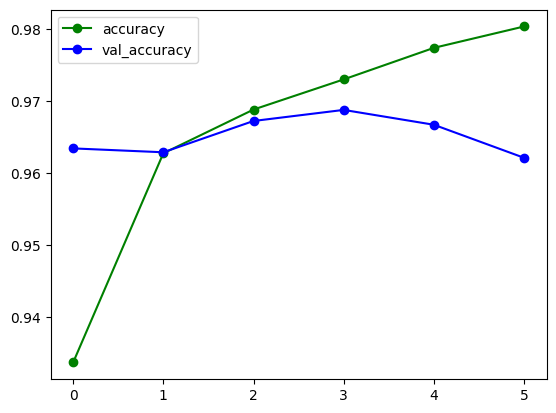

In [70]:
plt.plot(all_histories[2].history["auc_roc"],"go-",label="accuracy")
plt.plot(all_histories[2].history["val_auc_roc"],"bo-",label="val_accuracy")
plt.legend()
plt.show()

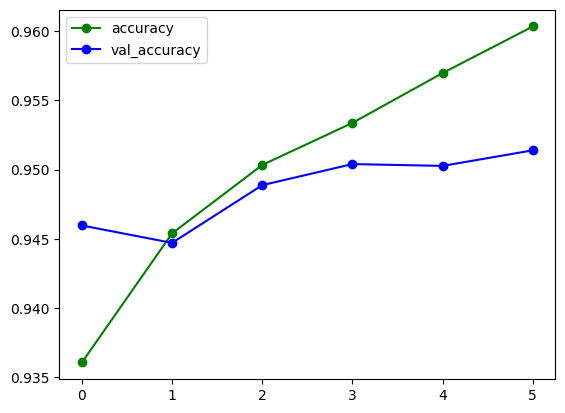

In [78]:
plt.plot(all_histories[4].history["accuracy"],"go-",label="accuracy")
plt.plot(all_histories[4].history["val_accuracy"],"bo-",label="val_accuracy")
plt.legend()
plt.show()

In [85]:
import numpy as np

# Assuming all_fold_history is already defined as given in the previous examples

# Extract values from the history
val_tp = np.array(all_fold_history['val_true_positives'])
val_fp = np.array(all_fold_history['val_false_positives'])
val_tn = np.array(all_fold_history['val_true_negatives'])
val_fn = np.array(all_fold_history['val_false_negatives'])

# Compute TPR and FPR
tpr = val_tp / (val_tp + val_fn)  # True Positive Rate
fpr = val_fp / (val_fp + val_tn)  # False Positive Rate

# Calculate mean TPR and FPR across folds
mean_tpr = np.mean(tpr)
mean_fpr = np.mean(fpr)

# Print TPR and FPR for debugging
print(f'TPR: {tpr}')
print(f'FPR: {fpr}')
print(f'Mean TPR: {mean_tpr}')
print(f'Mean FPR: {mean_fpr}')


TPR: [0.62704082 0.62704082 0.62704082 0.62704082 0.62704082]
FPR: [0.03517702 0.03517702 0.03517702 0.03517702 0.03517702]
Mean TPR: 0.6270408163265306
Mean FPR: 0.03517701617464088


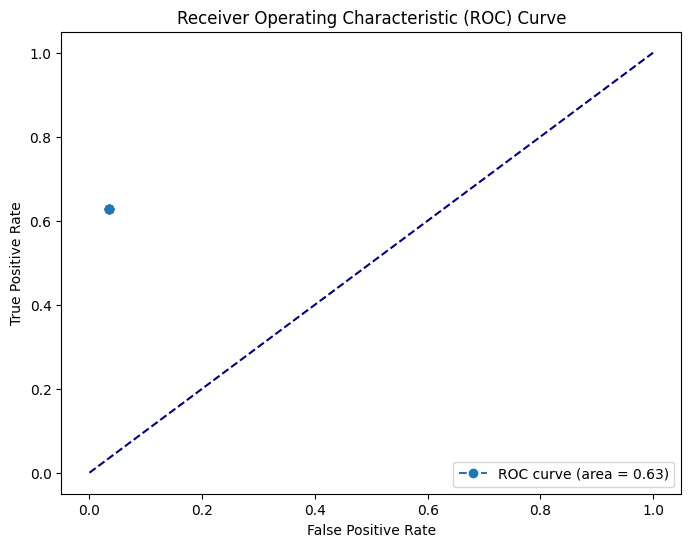

In [86]:
import matplotlib.pyplot as plt

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, marker='o', linestyle='--', label='ROC curve (area = %0.2f)' % mean_tpr)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# MFCC with Delta

In [82]:
def create_cnn_model(input_shape):
    model = Sequential([
        Conv2D(64, kernel_size=(2, 2), activation='relu', input_shape=input_shape,padding="same"),
        MaxPooling2D(pool_size=(2,2)),
        Dropout(0.2),
        Conv2D(128, kernel_size=(2, 2), activation='relu', input_shape=input_shape,padding="same"),
        MaxPooling2D(pool_size=(2,2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(8, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss="binary_crossentropy", optimizer="adam",
    metrics=[
            "accuracy",
            metrics.Precision(name='precision'),
            metrics.Recall(name='recall'),
            metrics.AUC(name='auc_roc', curve='ROC'),
            metrics.AUC(name='auc_pr', curve='PR'),
            metrics.TruePositives(name='true_positives'),
            metrics.FalsePositives(name='false_positives'),
            metrics.TrueNegatives(name='true_negatives'),
            metrics.FalseNegatives(name='false_negatives'),
])
    return model

model = create_cnn_model(input_shape=(64,14,3))
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 64, 14, 64)        832       
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 32, 7, 64)        0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 32, 7, 64)         0         
                                                                 
 conv2d_37 (Conv2D)          (None, 32, 7, 128)        32896     
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 16, 3, 128)       0         
 g2D)                                                            
                                                                 
 flatten_18 (Flatten)        (None, 6144)            

Sono Cross Val Split
 StratifiedKFold(n_splits=5, random_state=6, shuffle=True) 	Total Audio Files: 300


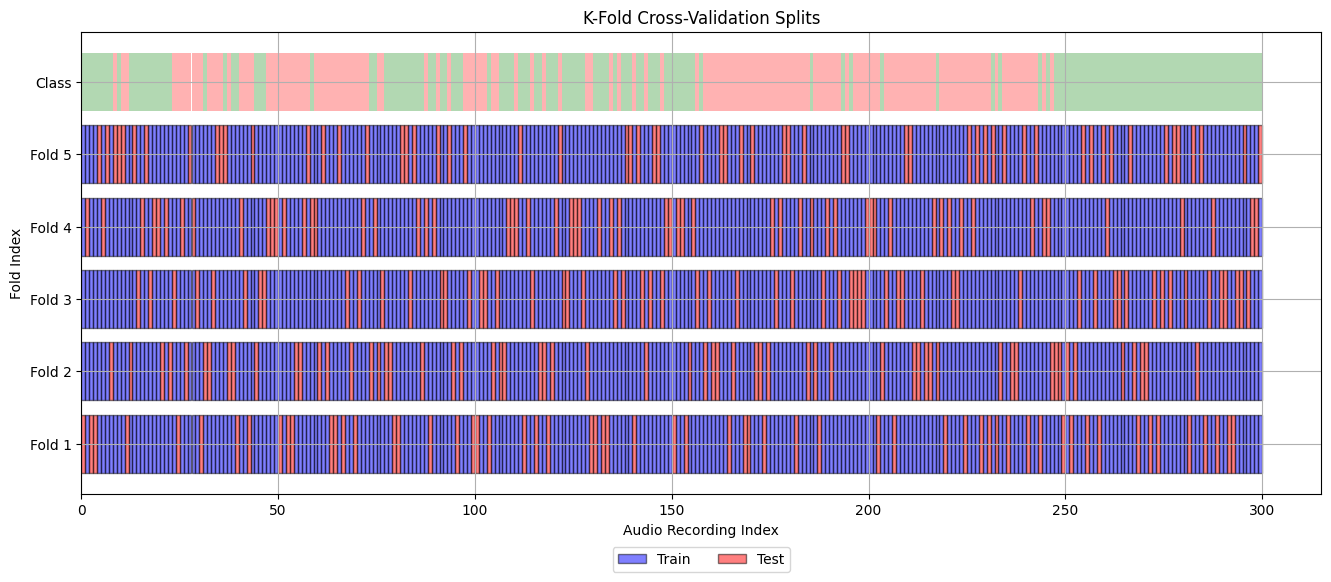

1 fold started
Epoch 1/6
1979/1979 [==============================] - 267s 133ms/step - loss: 0.2759 - accuracy: 0.8935 - precision: 0.5560 - recall: 0.0632 - auc_roc: 0.8144 - auc_pr: 0.3465 - true_positives: 432.0000 - false_positives: 345.0000 - true_negatives: 56138.0000 - false_negatives: 6400.0000 - val_loss: 0.2496 - val_accuracy: 0.9003 - val_precision: 0.5026 - val_recall: 0.0485 - val_auc_roc: 0.8434 - val_auc_pr: 0.3512 - val_true_positives: 95.0000 - val_false_positives: 94.0000 - val_true_negatives: 17588.0000 - val_false_negatives: 1865.0000
Epoch 2/6
1979/1979 [==============================] - 268s 135ms/step - loss: 0.2546 - accuracy: 0.8969 - precision: 0.5817 - recall: 0.1594 - auc_roc: 0.8533 - auc_pr: 0.4172 - true_positives: 1089.0000 - false_positives: 783.0000 - true_negatives: 55700.0000 - false_negatives: 5743.0000 - val_loss: 0.2515 - val_accuracy: 0.9009 - val_precision: 0.5528 - val_recall: 0.0347 - val_auc_roc: 0.8513 - val_auc_pr: 0.3722 - val_true_positi

KeyboardInterrupt: 

In [84]:
def train_with_cross_val_data():
    cv_strat = CrossValSplit(df_single_frame=audio_df_with_mfccs, non_cough_keys=audio_df[audio_df['cough_start_end'].isna()].index)
    cv_strat_data = cv_strat.cross_val(stratified=True, shuffle=True, plot=True, show_fold_info=False)

    all_histories_delta = []
    count = 1

    for fold in cv_strat_data:
        print(f"{count} fold started")
        model = create_cnn_model(input_shape=(64,16,3))

        X_train = final_mfcc_data[fold[0]]
        y_train = audio_df_with_mfccs.loc[fold[0]]["label"].values
        
        X_val = final_mfcc_data[fold[1]]
        y_val = audio_df_with_mfccs.loc[fold[1]]["label"].values
        history = model.fit(X_train, y_train, epochs=6, batch_size=32, validation_data=(X_val,y_val))
        all_histories_delta.append(history)
        count += 1
    return all_histories_delta

all_histories_delta = train_with_cross_val_data()